 ## HW3 - EuroSAT Land Use and Land Cover Classification using Deep Learning

Nissim Lebovits

March 17, 2023

In this homework your task is to implement traditional and DL models to solve a typical problem in satellite imaging  using a benchmark dataset.

### Notes:

For this assignment, I have used a number of additional sources, including [this Kaggle tutorial](https://www.kaggle.com/code/nilesh789/land-cover-classification-with-eurosat-dataset), ChatGPT, and Github Copilot.

### S1: Reading and Preparing the Data

#### Importing the Data

First, we'll import our libraries and read in our data.

In [2]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [65]:
url = 'C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750'

labels = os.listdir(url)

print(labels)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


#### Exploring the Data

We can take a look at the data to see the distribution by class.

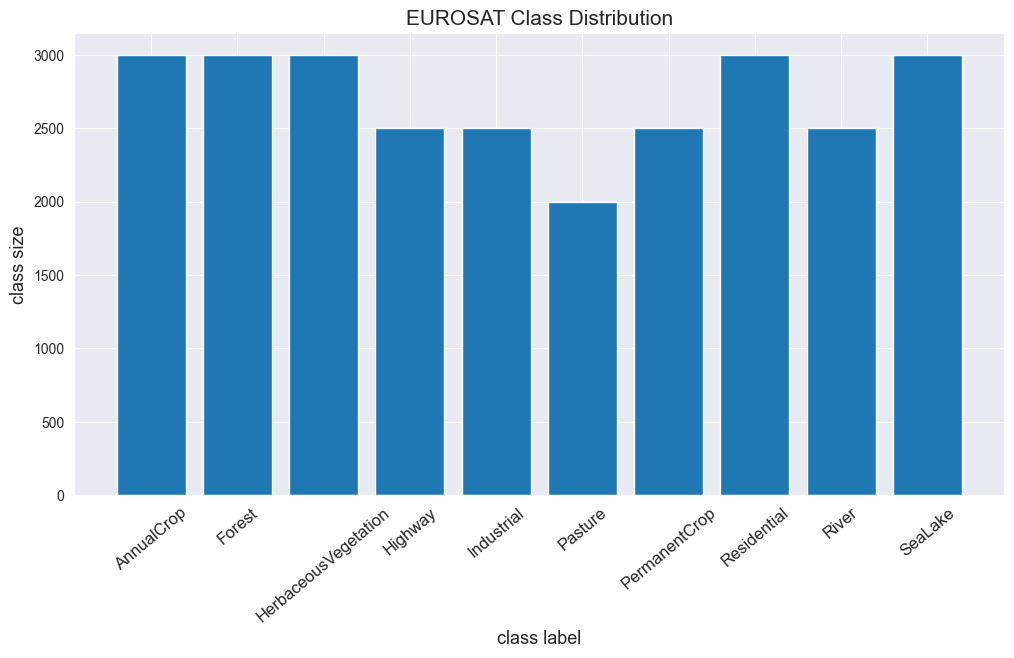

In [4]:
# plot class distributions of whole dataset
counts = {}

for l in labels:
    counts[l] = len(os.listdir(os.path.join(url, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

We can also visualize sample images from each class.

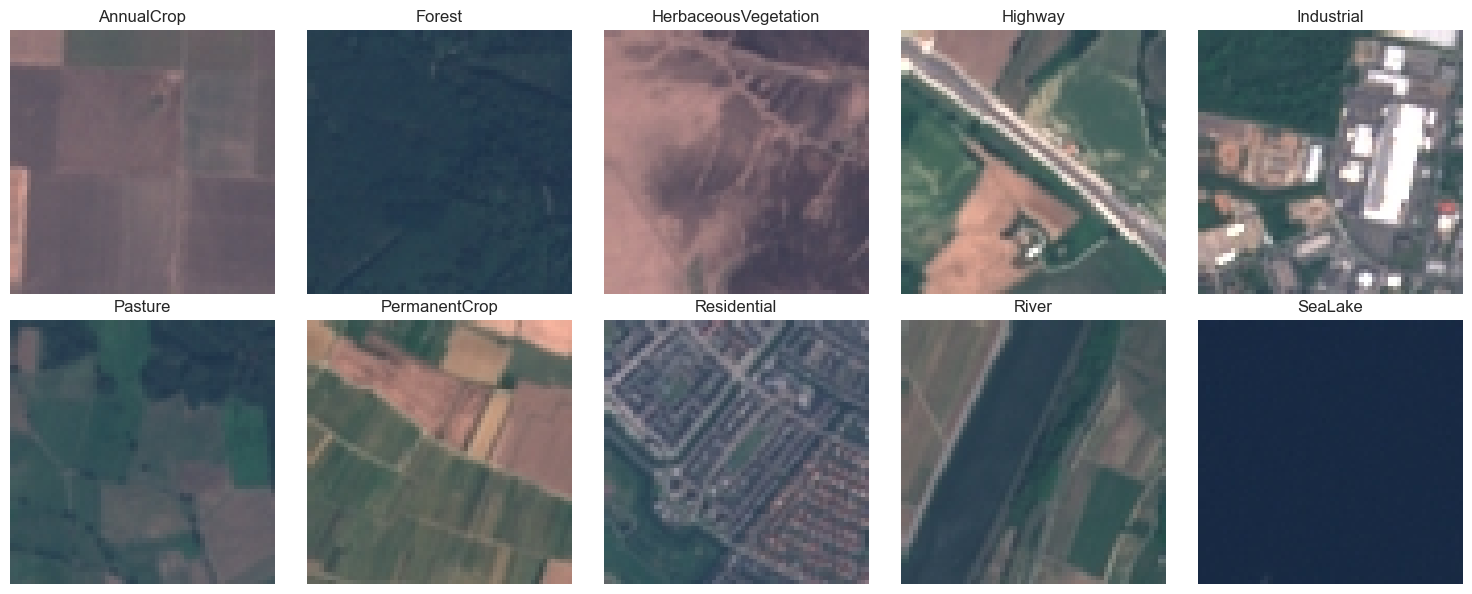

In [5]:
# plot one image from each class in a 2x5 grid
plt.figure(figsize=(15, 6))

for i, l in enumerate(labels):
    plt.subplot(2, 5, i+1)
    img = PIL.Image.open(os.path.join(url, l, os.listdir(os.path.join(url, l))[0]))
    plt.imshow(img)
    plt.title(l)
    plt.axis('off')

plt.tight_layout()
plt.show()

Now we'll import the data and split it into training and testing sets.

C:\Users\Nissim\Desktop\Spring 2023\Remote Sensing\MUSA-650_Spring2023\venv\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


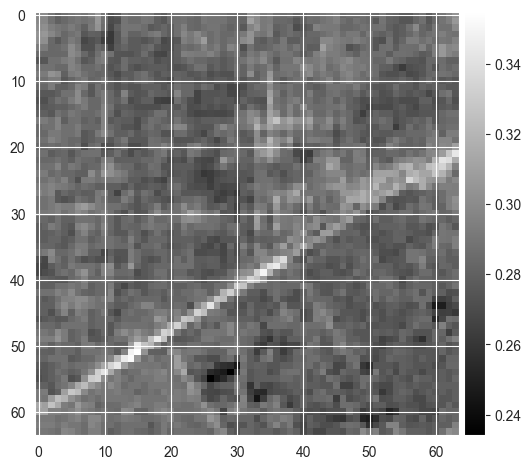

In [6]:
import numpy as np
from skimage import io, color

# Load an example image
img = io.imread("C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750/Forest/Forest_28.jpg")

# Check if the image is already grayscale
if len(img.shape) == 2 or np.allclose(img[...,0], img[...,1]) and np.allclose(img[...,0], img[...,2]):
    print('Image is already grayscale')
else:
    # Convert the image to grayscale using rgb2gray()
    gray_img = color.rgb2gray(img)
    io.imshow(gray_img, cmap='gray')
    io.show()

In [66]:
import os
import imageio.v2 as imageio
import numpy as np
from skimage import color

# Define the subfolder names
subfolders = ['Residential', 'Industrial', 'Forest']

# Initialize empty lists for images and labels
images = []
labels = []

# Loop over subfolders
for subfolder in subfolders:
    # Get list of image filenames in the current subfolder
    subfolder_path = os.path.join(url, subfolder)
    image_filenames = os.listdir(subfolder_path)

    # Load and append each image to images list
    for image_filename in image_filenames:
        image_path = os.path.join(subfolder_path, image_filename)
        image = imageio.imread(image_path)
        # Convert image to grayscale
        gray_image = color.rgb2gray(image)
        images.append(gray_image)
        labels.append(subfolder)

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

images.shape

(8500, 64, 64)

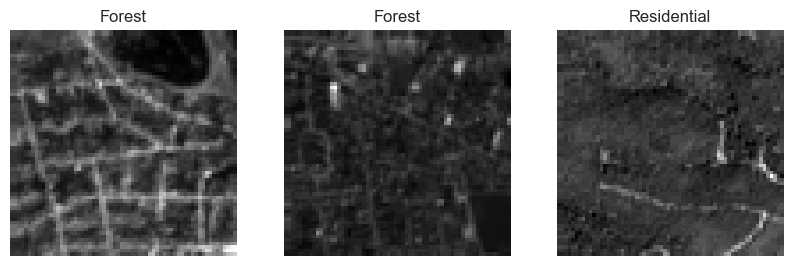

In [8]:
# print three random images from images with their labels
plt.figure(figsize=(10, 10))
for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[random.randint(0, len(images))], cmap="gray")
    plt.title(labels[random.randint(0, len(labels))])
    plt.axis("off")

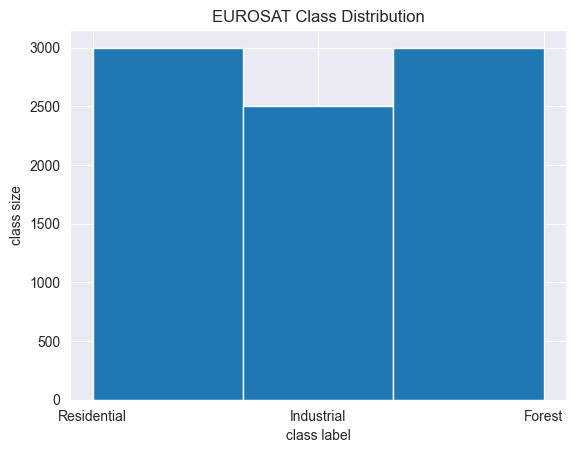

In [9]:
# plot a histogram of the distribution of labels in images
plt.hist(labels, bins=3)
plt.xticks([0, 1, 2], subfolders)
plt.xlabel('class label')
plt.ylabel('class size')
plt.title('EUROSAT Class Distribution');

Now we'll flatten the images.

In [67]:
# flatten images
images = images.reshape(images.shape[0], -1)

# print shape of images
images.shape

(8500, 4096)

#### Splitting the Data

We can now split the data into training and testing sets. We want a 60-40 split.

In [68]:
from sklearn.model_selection import train_test_split

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.4, random_state=42)

### S2: Binary Classifiers

SVM classifier for classes ('Forest', 'Industrial') Accuracy: 0.997246443322625
False label: Forest
True label: Industrial


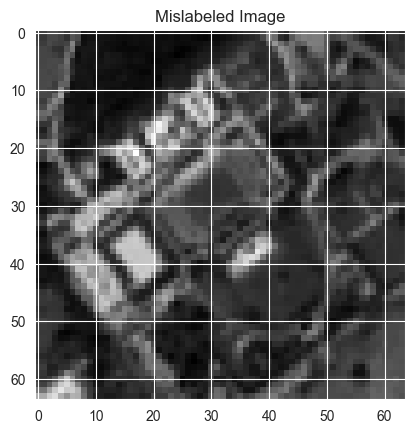

SVM classifier for classes ('Forest', 'Residential') Accuracy: 0.9558149228845352
False label: Forest
True label: Residential


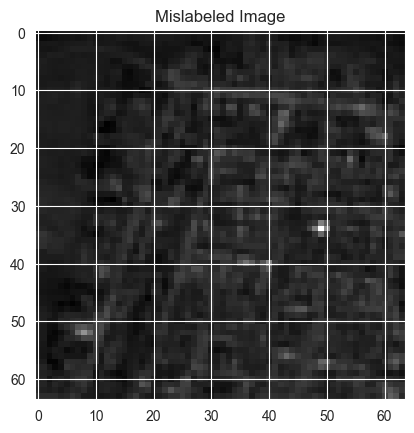

SVM classifier for classes ('Industrial', 'Residential') Accuracy: 0.7421242124212422
False label: Industrial
True label: Residential


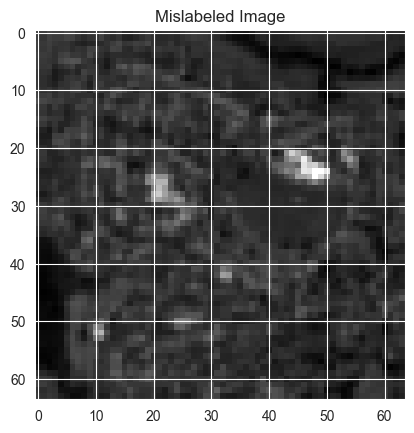

In [69]:
from itertools import combinations
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a list of class combinations
class_combinations = sorted(combinations(set(labels), 2))

# Train and evaluate each binary SVM classifier
for classes in class_combinations:
    # Filter the training and testing data for the current class combination
    images_train_filtered = images_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    labels_train_filtered = labels_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    images_test_filtered = images_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    labels_test_filtered = labels_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    
    # Create and train a binary SVM classifier for the current class combination
    svm = SVC(kernel='linear', C=1)
    svm.fit(images_train_filtered, labels_train_filtered)
    
    # Evaluate the performance of the binary SVM classifier on the filtered test data
    y_pred = svm.predict(images_test_filtered)
    accuracy = accuracy_score(labels_test_filtered, y_pred)
    
    # Print the accuracy score for the current binary SVM classifier
    print("SVM classifier for classes", classes, "Accuracy:", accuracy)

    # Find a mislabeled image
    misclassified_idx = np.where(y_pred != labels_test_filtered)[0][0]
    misclassified_img = images_test_filtered[misclassified_idx]
    misclassified_label = y_pred[misclassified_idx]
    true_label = labels_test_filtered[misclassified_idx]

    # Print the false and true labels
    print('False label: {}'.format(misclassified_label))
    print('True label: {}'.format(true_label))

    # Plot the misclassified image
    plt.imshow(misclassified_img.reshape(64, 64), cmap='gray')
    plt.title('Mislabeled Image')
    plt.show()

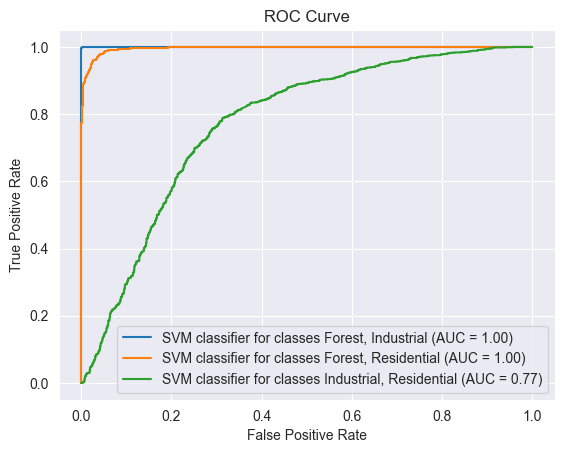

In [70]:
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Train and evaluate each binary SVM classifier
for classes in class_combinations:
    # Filter the training and testing data for the current class combination
    images_train_filtered = images_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    labels_train_filtered = labels_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    images_test_filtered = images_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    labels_test_filtered = labels_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    
    # Create and train a binary SVM classifier for the current class combination
    svm = SVC(kernel='linear', C=1, probability=True, random_state=42)
    svm.fit(images_train_filtered, labels_train_filtered)

    # Calculate the probabilities of the positive class for the filtered test data
    y_prob = svm.predict_proba(images_test_filtered)[:, 1]

    # Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
    fpr, tpr, thresholds = roc_curve(labels_test_filtered, y_prob, pos_label=classes[1])

    # Calculate the AUC for the ROC curve
    auc_score = auc(fpr, tpr)
    
    # Plot the ROC curve for the current binary SVM classifier
    plt.plot(fpr, tpr, label="SVM classifier for classes %s, %s (AUC = %.2f)" % (classes[0], classes[1], auc_score))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")

# Show the ROC curve plot
plt.show()

### S3: Multi-Class Classifiers via Majority Voting of Binary Classifiers

In [71]:
# Train and evaluate each binary SVM classifier
svm_classifiers = []
for classes in class_combinations:
    # Filter the training and testing data for the current class combination
    images_train_filtered = images_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    labels_train_filtered = labels_train[(labels_train == classes[0]) | (labels_train == classes[1])]
    images_test_filtered = images_test[(labels_test == classes[0]) | (labels_test == classes[1])]
    labels_test_filtered = labels_test[(labels_test == classes[0]) | (labels_test == classes[1])]

    # Create and train a binary SVM classifier for the current class combination
    svm = SVC(kernel='linear', C=1)
    svm.fit(images_train_filtered, labels_train_filtered)
    svm_classifiers.append(svm)

# Make predictions on the test data using each binary classifier
y_preds = []
for svm in svm_classifiers:
    y_pred = svm.predict(images_test)
    y_preds.append(y_pred)

# Combine the predictions using majority voting
y_pred_majority = []
for i in range(len(images_test)):
    class_votes = {}
    for y_pred in y_preds:
        pred_class = y_pred[i]
        if pred_class not in class_votes:
            class_votes[pred_class] = 0
        class_votes[pred_class] += 1
    majority_class = max(class_votes, key=class_votes.get)
    y_pred_majority.append(majority_class)

# Compute the classification accuracy
num_correct = sum([1 if y_pred == y_true else 0 for y_pred, y_true in zip(y_pred_majority, labels_test)])
accuracy = num_correct / len(labels_test)
print(f"Classification accuracy: {accuracy}")

Classification accuracy: 0.8014705882352942


### S4: Multi-Class Classifiers via Random-Forest Classifier

In [72]:
# using random forest classifier on images_train, images_test, labels_train, labels_test

from sklearn.ensemble import RandomForestClassifier

# Create and train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
rf.fit(images_train, labels_train)

# Evaluate the classifier on the test data
y_pred = rf.predict(images_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(labels_test, y_pred)

# Print the accuracy
print("Random Forest Classifier Accuracy:", accuracy)

Random Forest Classifier Accuracy: 0.9064705882352941


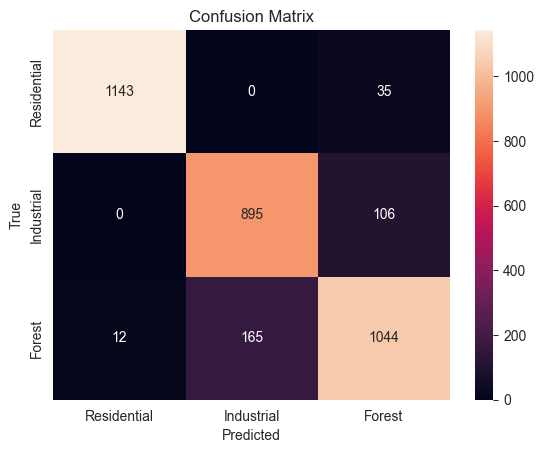

In [73]:
# print the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(labels_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=subfolders, yticklabels=subfolders)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix');

### S5: Fully-Connected Neural Network

Implement a deep learning model with fully connected layers using a single intermediate layer with 128 nodes.

I'm using one-hot encoding here to convert string labels to categorical labels that can be used in the neural network.

Epoch 1/10
40/40 [==============================] - 1s 11ms/step - loss: 1.2373 - accuracy: 0.3698 - val_loss: 1.0138 - val_accuracy: 0.4800
Epoch 2/10
40/40 [==============================] - 0s 9ms/step - loss: 0.9849 - accuracy: 0.4876 - val_loss: 0.9858 - val_accuracy: 0.5368
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 0.9192 - accuracy: 0.5335 - val_loss: 0.9021 - val_accuracy: 0.6929
Epoch 4/10
40/40 [==============================] - 0s 8ms/step - loss: 0.8924 - accuracy: 0.5484 - val_loss: 0.9082 - val_accuracy: 0.5841
Epoch 5/10
40/40 [==============================] - 0s 9ms/step - loss: 0.8611 - accuracy: 0.5947 - val_loss: 0.8690 - val_accuracy: 0.7568
Epoch 6/10
40/40 [==============================] - 0s 8ms/step - loss: 0.8398 - accuracy: 0.6200 - val_loss: 0.8379 - val_accuracy: 0.8118
Epoch 7/10
40/40 [==============================] - 0s 8ms/step - loss: 0.8103 - accuracy: 0.6698 - val_loss: 0.8479 - val_accuracy: 0.6550
Epoch 8/10
40/40 [=

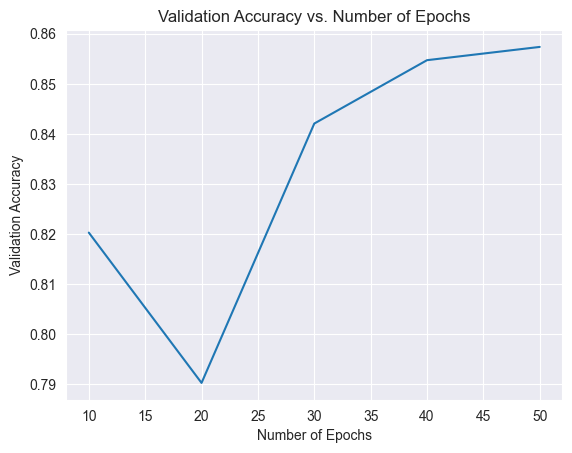

In [90]:
import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

batch_size = 128
num_classes = 3
epochs_list = [10, 20, 30, 40, 50]
val_acc_history = []

# create label encoder
le = LabelEncoder()

# fit label encoder and transform labels
labels_train_int = le.fit_transform(labels_train)
labels_test_int = le.transform(labels_test)

# convert integer-encoded labels to one-hot encoded labels
labels_train_onehot = to_categorical(labels_train_int, num_classes)
labels_test_onehot = to_categorical(labels_test_int, num_classes)

best_score = 0
best_epochs = 0

for epochs in epochs_list:
    model = Sequential()

    model.add(Dense(128, input_shape=(4096,), activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit(images_train, labels_train_onehot,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(images_test, labels_test_onehot))

    val_acc_history.append(history.history['val_accuracy'][-1])
    score = model.evaluate(images_test, labels_test_onehot, verbose=0)
    print(f'Validation loss for {epochs} epochs:', score[0])
    print(f'Validation accuracy for {epochs} epochs:', score[1])
    if score[1] > best_score:
        best_score = score[1]
        best_epochs = epochs

print('Best number of epochs:', best_epochs)
print('Best validation accuracy:', best_score)

plt.plot(epochs_list, val_acc_history)
plt.title('Validation Accuracy vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

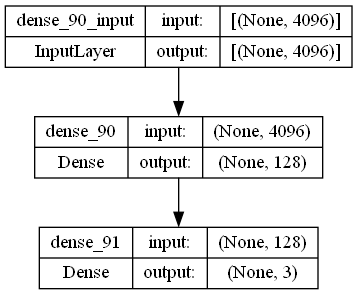

In [84]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### S6: Variations of Network Architectures

Compare the previous network to an alternative one using 4 intermediate layers with 32 nodes in each.

Epoch 1/10
40/40 [==============================] - 1s 9ms/step - loss: 1.0644 - accuracy: 0.3510 - val_loss: 1.0107 - val_accuracy: 0.4185
Epoch 2/10
40/40 [==============================] - 0s 5ms/step - loss: 0.9474 - accuracy: 0.5075 - val_loss: 0.8896 - val_accuracy: 0.6535
Epoch 3/10
40/40 [==============================] - 0s 5ms/step - loss: 0.8343 - accuracy: 0.6816 - val_loss: 0.7907 - val_accuracy: 0.7850
Epoch 4/10
40/40 [==============================] - 0s 5ms/step - loss: 0.7645 - accuracy: 0.7584 - val_loss: 0.7282 - val_accuracy: 0.8218
Epoch 5/10
40/40 [==============================] - 0s 5ms/step - loss: 0.6922 - accuracy: 0.8157 - val_loss: 0.6913 - val_accuracy: 0.8009
Epoch 6/10
40/40 [==============================] - 0s 5ms/step - loss: 0.6418 - accuracy: 0.8014 - val_loss: 0.6014 - val_accuracy: 0.8418
Epoch 7/10
40/40 [==============================] - 0s 5ms/step - loss: 0.5765 - accuracy: 0.8202 - val_loss: 0.5847 - val_accuracy: 0.7706
Epoch 8/10
40/40 [==

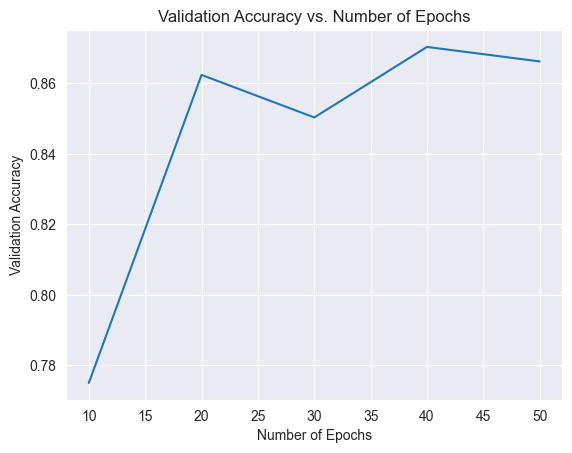

In [82]:
import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D
import matplotlib.pyplot as plt

two_val_acc_history = []
two_best_score = 0
two_best_epochs = 0

for epochs in epochs_list:
    model_two = Sequential()

    model_two.add(Dense(32, input_shape=(4096,), activation='relu'))
    model_two.add(Dense(32, input_shape=(4096,), activation='relu'))
    model_two.add(Dense(32, input_shape=(4096,), activation='relu'))
    model_two.add(Dense(32, input_shape=(4096,), activation='relu'))
    model_two.add(Dense(num_classes, activation='softmax'))

    model_two.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer='adam',
                      metrics=['accuracy'])

    history = model_two.fit(images_train, labels_train_onehot,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(images_test, labels_test_onehot))

    two_val_acc_history.append(history.history['val_accuracy'][-1])
    score = model_two.evaluate(images_test, labels_test_onehot, verbose=0)
    print(f'Validation loss for {epochs} epochs:', score[0])
    print(f'Validation accuracy for {epochs} epochs:', score[1])
    if score[1] > two_best_score:
        two_best_score = score[1]
        two_best_epochs = epochs

print('Best number of epochs:', two_best_epochs)
print('Best validation accuracy:', two_best_score)

plt.plot(epochs_list, two_val_acc_history)
plt.title('Validation Accuracy vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

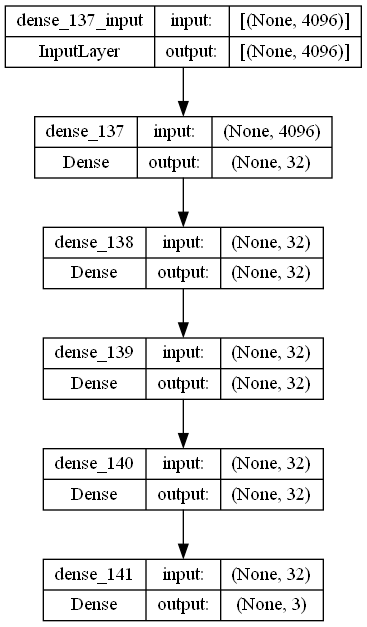

In [83]:
from keras.utils.vis_utils import plot_model
plot_model(model_two, show_shapes=True, show_layer_names=True)

#### Q6.1: Which network has more parameters to learn? How many more parameters?

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 524,803
Trainable params: 524,803
Non-trainable params: 0
_________________________________________________________________


In [25]:
model_two.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                131104    
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 134,371
Trainable params: 134,371
Non-trainable params: 0
_________________________________________________________________


According to these summaries, the first model with 128 nodes has 524,416 parameters to learn, while the second model with 4 layers of 32 nodes each has 131,104 parameters to learn. This means that the first model has 393,312 more parameters to learn than the second model.

#### Q6.2: Which network has a higher validation accuracy?

Originally, when I was using the Adadelta optimizer, the network with only 1 layer and 128 nodes had a higher validation accuracy (0.454) than the network with 4 layers and 32 nodes each (0.376). This was still not a very high validation accuracy. However, when I switched to the Adam optimizer, the opposite was true. The network with 4 layers and 32 nodes each had a validation accuracy of 0.861, while the network with 1 layer and 128 nodes had a validation accuracy of only 0.810. Finally, I added a loop to run through five different options for the number of epochs: 10, 20, 30, 40, and 50. I found that model_two, which 4 layers of 32 nodes each, had a slightly higher peak validation accuracy of 0.870  at 40 epochs, while model had a peak validation accuracy of 0.850 at 30 epochs.

I also tried messing around with creating a different model. The big difference maker here seemed to be switching to an "adam" optimizer, which increased the validation accuracy by about 30%. Interestingly, in playing around with the parameters, I found that both increasing the number of nodes and adding dropout layers significantly decreased the validation accuracy. The 32x32x32x32 architecture actually seems to perform best. Adding another layer of 32 nodes also decreased the accuracy. Ultimately, the model 4 layers of 32 nodes and no dropout layers performed the best of out any neutral net I tried over than the CNN (see below), which surprised me.

#### Addendum

Finally, out of curiosity, I wanted to see how a CNN would perform on these data. I made the one below using Copilot:

Epoch 1/10
40/40 [==============================] - 8s 174ms/step - loss: 1.0358 - accuracy: 0.6633 - val_loss: 0.3589 - val_accuracy: 0.8271
Epoch 2/10
40/40 [==============================] - 7s 175ms/step - loss: 0.2946 - accuracy: 0.8645 - val_loss: 0.3074 - val_accuracy: 0.8432
Epoch 3/10
40/40 [==============================] - 7s 177ms/step - loss: 0.2969 - accuracy: 0.8590 - val_loss: 0.2649 - val_accuracy: 0.8850
Epoch 4/10
40/40 [==============================] - 7s 179ms/step - loss: 0.2546 - accuracy: 0.8814 - val_loss: 0.2677 - val_accuracy: 0.8779
Epoch 5/10
40/40 [==============================] - 7s 177ms/step - loss: 0.2033 - accuracy: 0.9106 - val_loss: 0.1598 - val_accuracy: 0.9309
Epoch 6/10
40/40 [==============================] - 7s 183ms/step - loss: 0.2423 - accuracy: 0.9010 - val_loss: 0.2035 - val_accuracy: 0.8950
Epoch 7/10
40/40 [==============================] - 7s 186ms/step - loss: 0.1410 - accuracy: 0.9449 - val_loss: 0.1031 - val_accuracy: 0.9621
Epoch 

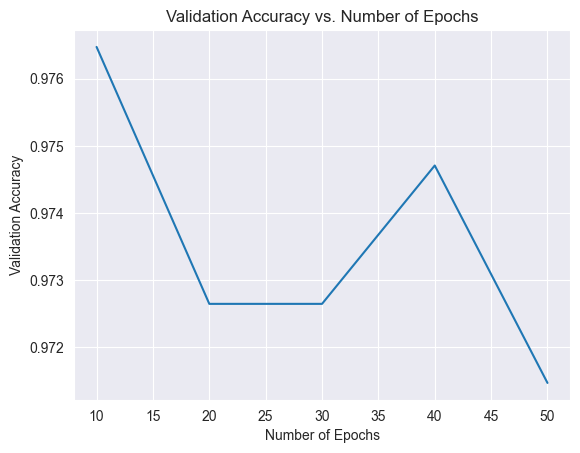

In [86]:
import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# reshape images_train and images_test in preparation for feeding them into a CNN
images_train_reshape = np.reshape(images_train, (-1, 64, 64, 1))
images_test_reshape = np.reshape(images_test, (-1, 64, 64, 1))

three_val_acc_history = []
three_best_score = 0
three_best_epochs = 0

for epochs in epochs_list:
    model_three = Sequential()

    model_three.add(Conv2D(16, kernel_size=5, padding='same', activation='elu', input_shape=(64, 64, 1)))
    model_three.add(MaxPooling2D())

    model_three.add(Conv2D(32, 3, padding='same', activation='elu'))
    model_three.add(Conv2D(32, 3, padding='same', activation='elu'))
    model_three.add(MaxPooling2D())

    model_three.add(Conv2D(64, 3, padding='same', activation='elu'))
    model_three.add(Conv2D(64, 3, padding='same', activation='elu'))

    model_three.add(Flatten())
    model_three.add(Dense(128, activation='elu'))
    model_three.add(Dense(num_classes, activation='softmax'))

    model_three.compile(loss=keras.losses.categorical_crossentropy,
                        optimizer='adam',
                        metrics=['accuracy'])

    history = model_three.fit(images_train_reshape, labels_train_onehot,
                              batch_size=batch_size,
                              epochs=epochs,
                              verbose=1,
                              validation_data=(images_test_reshape, labels_test_onehot))

    three_val_acc_history.append(history.history['val_accuracy'][-1])
    score = model_three.evaluate(images_test_reshape, labels_test_onehot, verbose=0)
    print(f'Validation loss for {epochs} epochs:', score[0])
    print(f'Validation accuracy for {epochs} epochs:', score[1])
    if score[1] > three_best_score:
        three_best_score = score[1]
        three_best_epochs = epochs

print('Best number of epochs:', three_best_epochs)
print('Best validation accuracy:', three_best_score)

plt.plot(epochs_list, three_val_acc_history)
plt.title('Validation Accuracy vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.show()

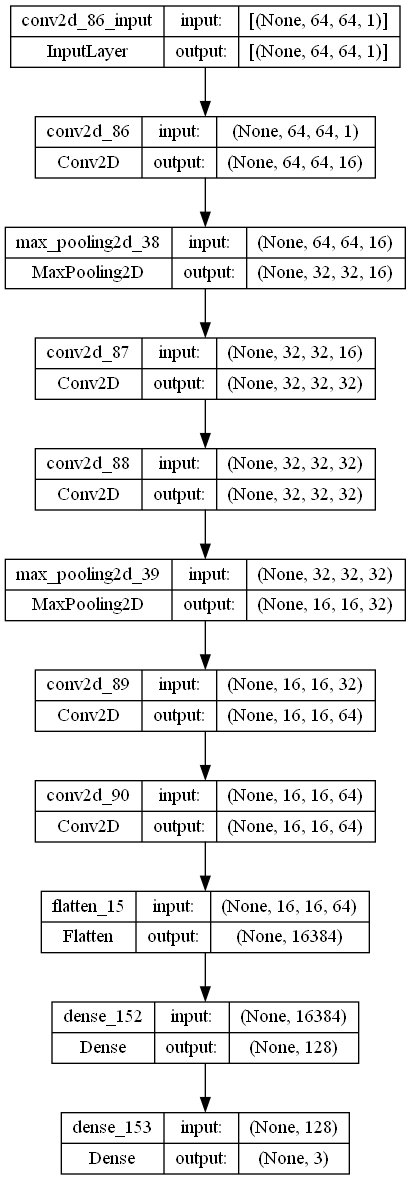

In [87]:
from keras.utils.vis_utils import plot_model
plot_model(model_three, show_shapes=True, show_layer_names=True)

I'm pretty happy with this model. Its test accuracy of 0.976 compares favorably with  model from [this Kaggle example](https://www.kaggle.com/code/ryanholbrook/starter-eurosat), which had a test accuracy in a similar range.

Finally, we can compare the peak validation accuracy for the three models at each number of epochs:

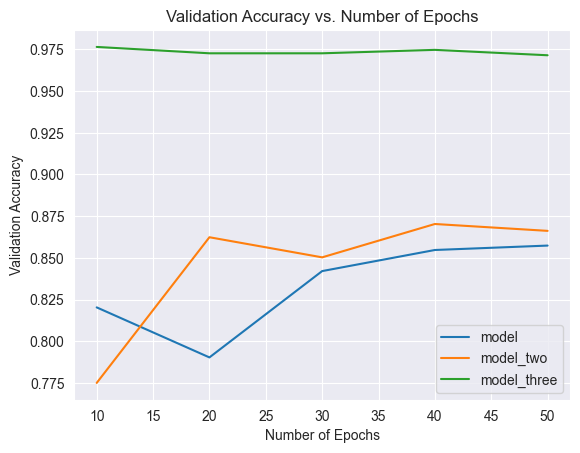

In [93]:
# Plot val_acc_history, two_val_acc_history, and three_val_acc_history against epochs list on the same scatter plot.
plt.plot(epochs_list, val_acc_history, label='model')
plt.plot(epochs_list, two_val_acc_history, label='model_two')
plt.plot(epochs_list, three_val_acc_history, label='model_three')
plt.title('Validation Accuracy vs. Number of Epochs')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

### Addendum 2: Testing on all 10 classes

Again, out of curiousity, I thought I would run the full dataset with all 10 classes through the best model, the CNN that I just laid out above. I'm curious to see what the test accuracy rate is, and whether adding in more nuanced classes will lower it. Note that I am *not* looping through the list of possible epochs, because that would be prohibitively time-consuming.

In [64]:
import os
import imageio.v2 as imageio
import numpy as np
from skimage import color

# Define the subfolder names
url = 'C:/Users/Nissim/Desktop/Spring 2023/Remote Sensing/MUSA-650_Spring2023/Homeworks/EuroSAT_RGB/2750'

new_subfolders = os.listdir(url)

# Initialize empty lists for images and labels
full_images = []
full_labels = []

# Loop over subfolders
for subfolder in new_subfolders:
    # Get list of image filenames in the current subfolder
    subfolder_path = os.path.join(url, subfolder)
    image_filenames = os.listdir(subfolder_path)

    # Load and append each image to images list
    for image_filename in image_filenames:
        image_path = os.path.join(subfolder_path, image_filename)
        image = imageio.imread(image_path)
        # Convert image to grayscale
        gray_image = color.rgb2gray(image)
        full_images.append(gray_image)
        full_labels.append(subfolder)

# Convert images and labels to numpy arrays
full_images = np.array(full_images)
full_labels = np.array(full_labels)

full_images.shape

(27000, 64, 64)

In [51]:
from sklearn.model_selection import train_test_split

full_images_train, full_images_test, full_labels_train, full_labels_test = train_test_split(full_images, full_labels, test_size=0.4, random_state=42)

In [57]:
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils import to_categorical

batch_size = 128
full_num_classes = 10
full_epochs = 20

from sklearn.preprocessing import LabelEncoder

# create label encoder
le = LabelEncoder()

# fit label encoder and transform labels
full_labels_train_int = le.fit_transform(full_labels_train)
full_labels_test_int = le.transform(full_labels_test)

# convert integer-encoded labels to one-hot encoded labels
full_labels_train_onehot = to_categorical(full_labels_train_int, full_num_classes)
full_labels_test_onehot = to_categorical(full_labels_test_int, full_num_classes)

In [58]:
from keras.layers import MaxPooling2D

# create a CNN
model_four = Sequential()

model_four.add(Conv2D(16, kernel_size=5, padding='same', activation='elu', input_shape=(64, 64, 1)))
model_four.add(MaxPooling2D())

model_four.add(Conv2D(32, 3, padding='same', activation='elu'))
model_four.add(Conv2D(32, 3, padding='same', activation='elu'))
model_four.add(MaxPooling2D())

model_four.add(Conv2D(64, 3, padding='same', activation='elu'))
model_four.add(Conv2D(64, 3, padding='same', activation='elu'))

model_four.add(Flatten())
model_four.add(Dense(128, activation='elu'))

model_four.add(Dense(full_num_classes, activation='softmax'))

model_four.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model_four.fit(full_images_train, full_labels_train_onehot,
            batch_size=batch_size,
            epochs=full_epochs,
            verbose=1,
            validation_data=(full_images_test, full_labels_test_onehot))

score = model_four.evaluate(full_images_test, full_labels_test_onehot, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Epoch 1/20
127/127 [==============================] - 23s 177ms/step - loss: 1.5566 - accuracy: 0.4073 - val_loss: 1.2228 - val_accuracy: 0.5294
Epoch 2/20
127/127 [==============================] - 23s 184ms/step - loss: 1.2413 - accuracy: 0.5444 - val_loss: 1.3009 - val_accuracy: 0.4962
Epoch 3/20
127/127 [==============================] - 24s 187ms/step - loss: 1.1243 - accuracy: 0.5853 - val_loss: 1.0322 - val_accuracy: 0.6206
Epoch 4/20
127/127 [==============================] - 23s 178ms/step - loss: 0.9941 - accuracy: 0.6312 - val_loss: 0.9703 - val_accuracy: 0.6396
Epoch 5/20
127/127 [==============================] - 22s 176ms/step - loss: 0.8566 - accuracy: 0.6848 - val_loss: 0.8555 - val_accuracy: 0.6796
Epoch 6/20
127/127 [==============================] - 34s 270ms/step - loss: 0.7776 - accuracy: 0.7104 - val_loss: 0.8428 - val_accuracy: 0.6888
Epoch 7/20
127/127 [==============================] - 39s 305ms/step - loss: 0.6892 - accuracy: 0.7438 - val_loss: 0.8412 - val_ac

The test accuracy here was significantly lower than with the 3-class dataset: only 0.716. At one point, I tried using 50 epochs instead of 20, based on [this Kaggle example](https://www.kaggle.com/code/ryanholbrook/starter-eurosat). That actually ended up decreasing the test accuracy, and at that point I gave up because the training took so long, since I don't have `tensorflow` set up to run on my GPU.